# Figure planner

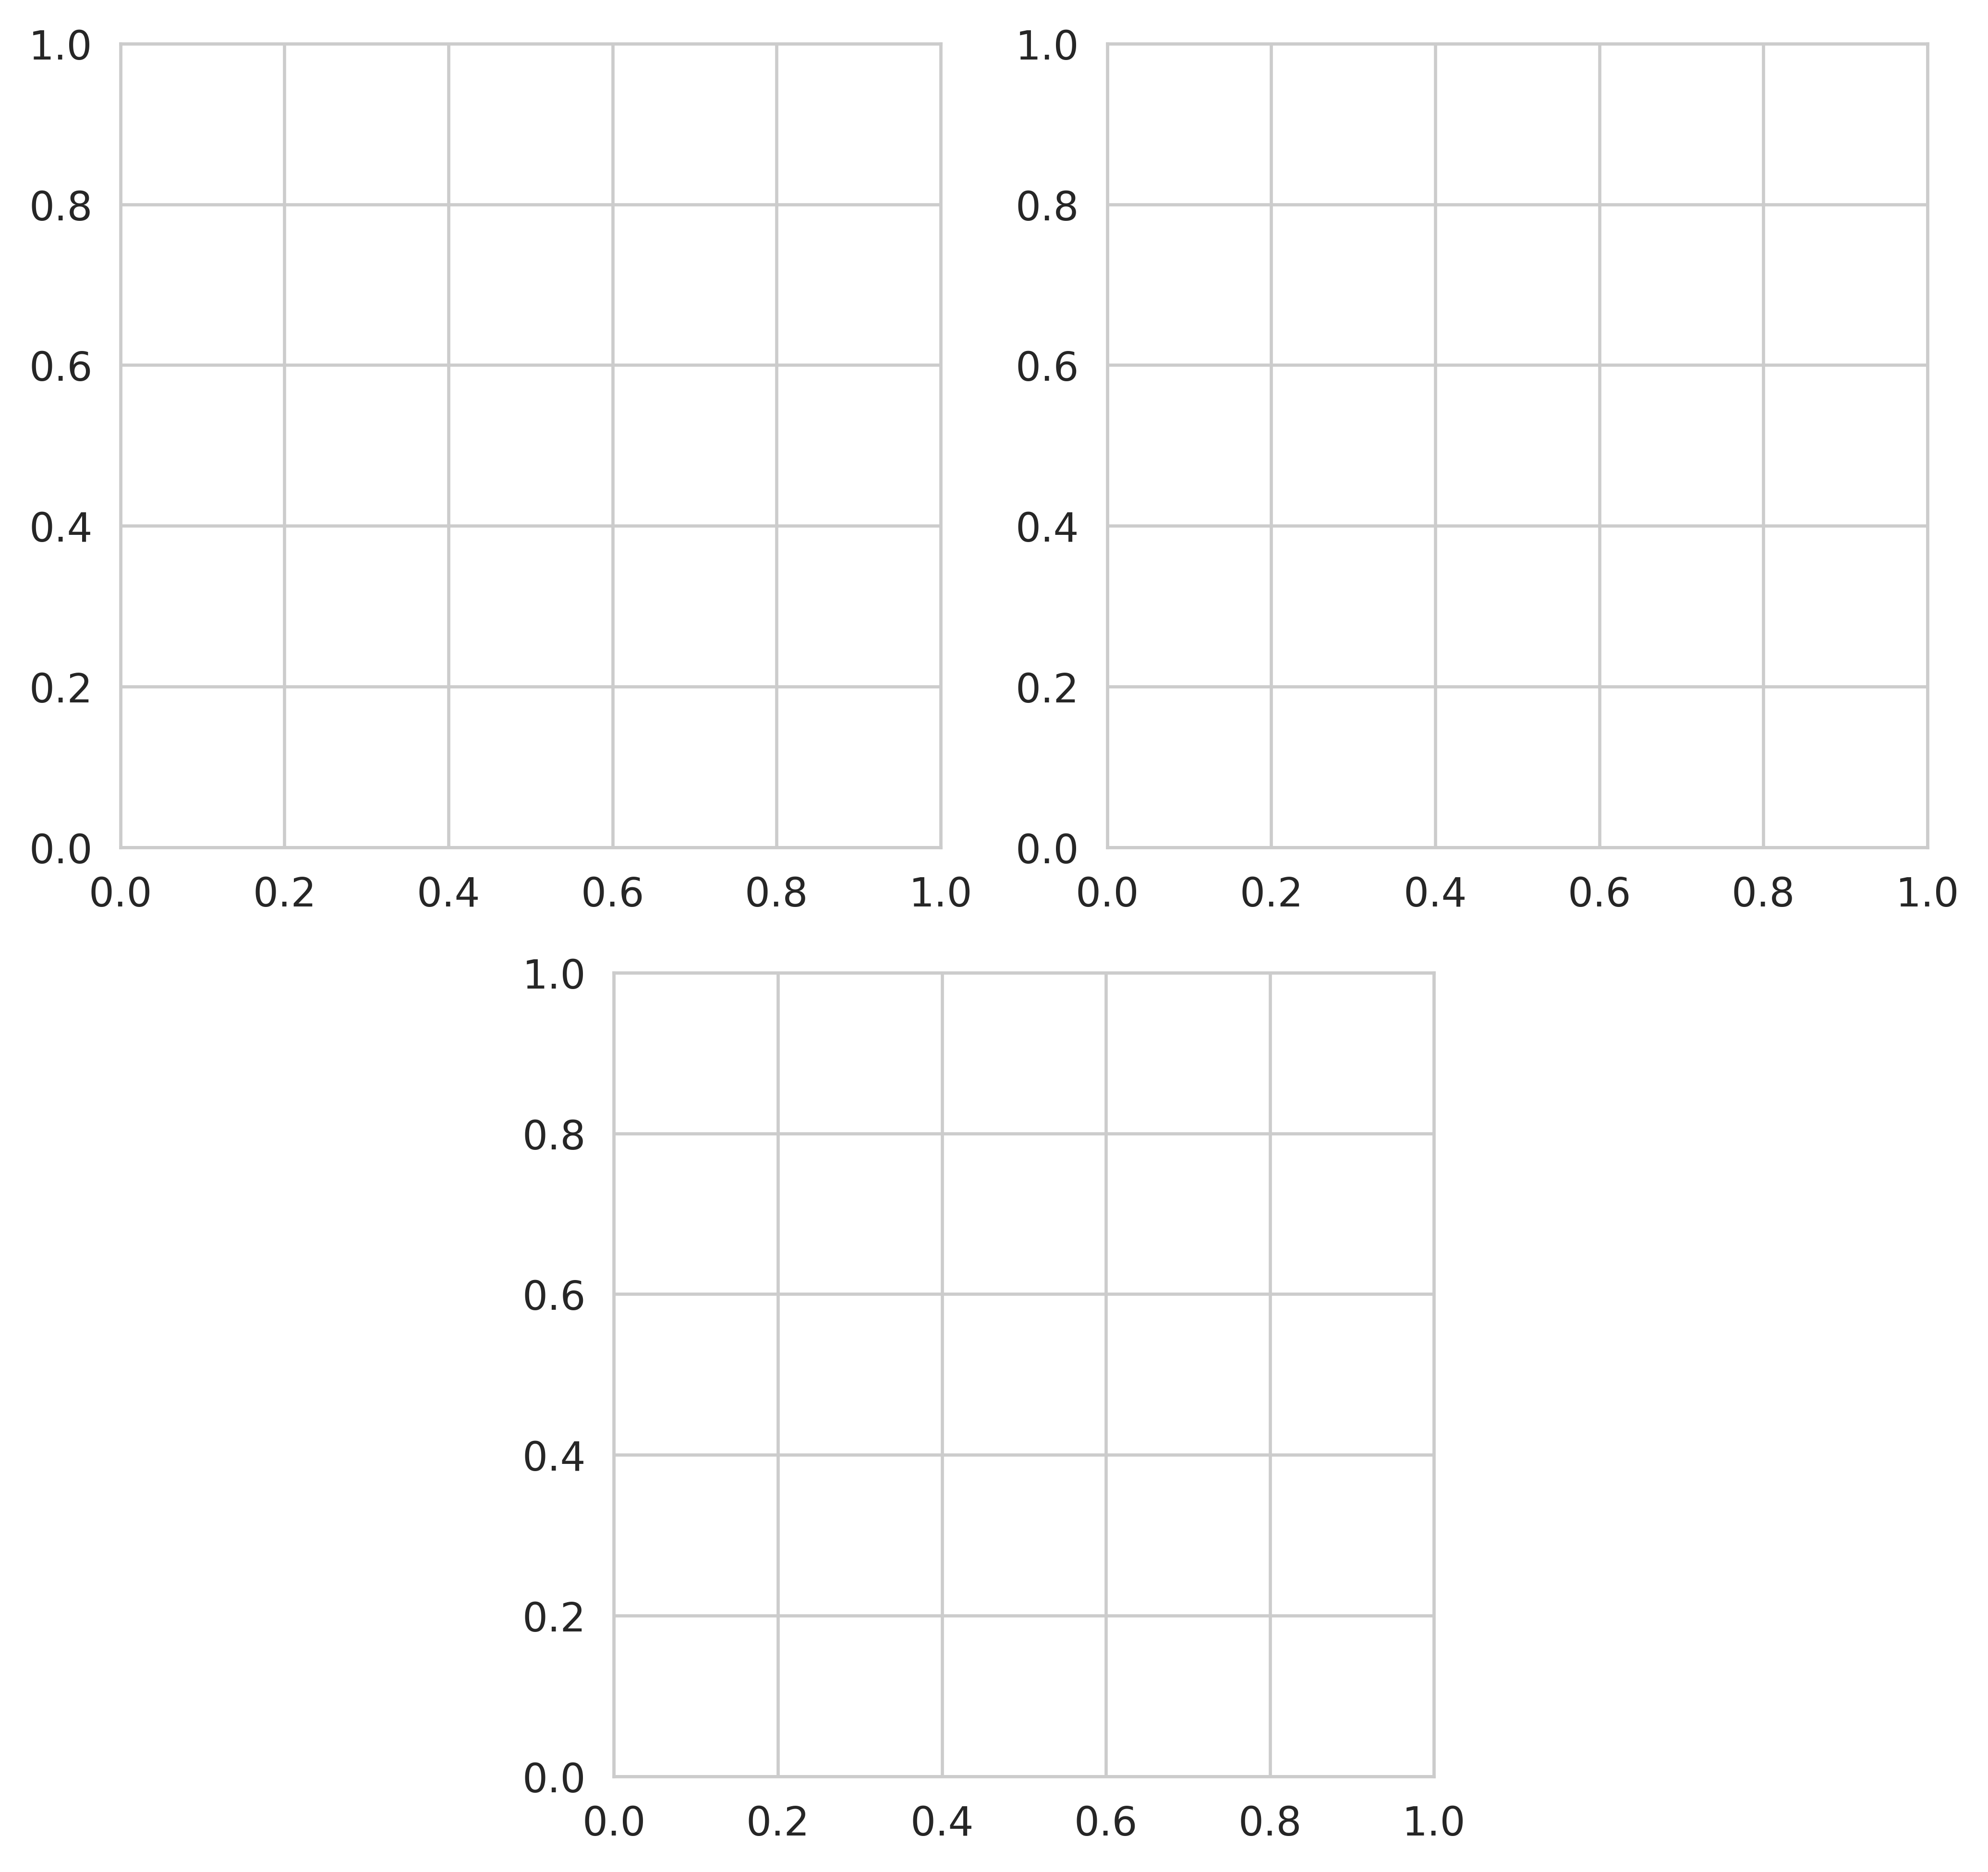

In [8]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig1 = plt.figure(figsize=(7, 6.6), dpi=600)

gs1 = GridSpec(2, 4, fig1)

ax00 = fig1.add_subplot(gs1[0, :2])
ax01 = fig1.add_subplot(gs1[0, 2:])
ax1 = fig1.add_subplot(gs1[1, 1:3])


# ax00.set_aspect("equal")
# ax01.set_aspect("equal")
# ax002.set_aspect("equal")

fig1.tight_layout()

# Figure 1

In [71]:
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from Checkpoints import Checkpoint
import numpy as np
from sklearn import metrics
from sklearn import preprocessing

##### Fig1 #####
sns.set_style("whitegrid")
sns.set_palette("crest")

fig1 = plt.figure(figsize=(12, 11), dpi=600)
gs1 = GridSpec(2, 2, fig1)

##### ax00 ##### 

ax00 = fig1.add_subplot(gs1[0, 0])

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

ax00.set_aspect("equal")
div00 = make_axes_locatable(ax00)
cax00 = div00.append_axes("right", size="5%", pad=0.05)
sns.histplot(two_mod_wide, x="percentMeth_WGBS", y="percentMeth_Nanopore", 
             bins=20, pthresh=0.01, stat="proportion", cbar=True, cbar_kws={"label" : "Proportion"}, cbar_ax=cax00, ax=ax00)

ax00.set_xlim((0, 100))
ax00.set_ylim((0, 100))
ax00.set_xlabel("WGBS \u03B2$_{\%}$")
ax00.set_ylabel("Nanopore \u03B2$_{\%}$")
ax00.set_title("A", loc="left")

##### ax01 ##### 

ax01 = fig1.add_subplot(gs1[0, 1])

if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

ax01.set_aspect("equal")
div01 = make_axes_locatable(ax01)
cax01 = div01.append_axes("right", size="5%", pad=0.05)
sns.histplot(mc_df_wide, x="percentMeth_oxBS_5mC", y="percentMeth_Nanopore_5mC", 
             bins=20, pthresh=0.01, stat="proportion", cbar=True, cbar_kws={"label" : "Proportion"}, cbar_ax=cax01, ax=ax01)

ax01.set_xlim((0, 100))
ax01.set_ylim((0, 100))
ax01.set_xlabel("oxBS \u03B2$_{\%}$")
ax01.set_ylabel("Nanopore \u03B2$_{\%}$")
ax01.set_title("B", loc="left")
ax01.xaxis.set_major_locator(MultipleLocator(20))

##### ax10 ##### 

if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

ax10 = fig1.add_subplot(gs1[1, 0])

ax10.set_aspect("equal")
div10 = make_axes_locatable(ax10)
cax10 = div10.append_axes("right", size="5%", pad=0.05)
sns.histplot(hmc_df_wide, x="percentMeth_TAB_5hmC", y="percentMeth_Nanopore_5hmC", 
             bins=20, pthresh=0.01, stat="proportion", cbar=True, cbar_kws={"label" : "Proportion"}, cbar_ax=cax10, ax=ax10)

ax10.set_xlim((0, 100))
ax10.set_ylim((0, 100))
ax10.set_xlabel("TAB \u03B2$_{\%}$")
ax10.set_ylabel("Nanopore \u03B2$_{\%}$")
ax10.set_title("C", loc="left")
ax10.xaxis.set_major_locator(MultipleLocator(20))

##### ax11 ##### 

ax11 = fig1.add_subplot(gs1[1, 1])

ax11.set_aspect("equal")
ax11.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")

for i, df in enumerate([two_mod_wide, mc_df_wide, hmc_df_wide]):
    binariser =  preprocessing.Binarizer(threshold=50)
    df["binarised"] = binariser.fit_transform(np.reshape(df.iloc[:, 5].to_numpy(), (-1, 1)))
    metrics.RocCurveDisplay.from_predictions(df["binarised"], df.iloc[:, -3], label=["vs. WGBS", "vs. oxBS", "vs. TAB"][i], ls=["-", "--", ":"][i], ax=ax11)

ax11.set_title("D", loc="left")
ax11.legend()

##### Save Figure ##### 

fig1.tight_layout()
fig1.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure1.png', bbox_inches="tight")
plt.close()

## Figure 1 Stats

In [199]:
len(hmc_df_wide.loc[(hmc_df_wide.loc[:, "binarised"] == 1.0) & (hmc_df_wide.loc[:, "percentMeth_Nanopore_5hmC"] >= 50)])/len(hmc_df_wide.loc[(hmc_df_wide.loc[:, "binarised"] == 1.0)])

0.34266881563446344

In [1]:
import numpy as np
from sklearn import metrics
from scipy import stats
import pandas as pd
from Checkpoints import Checkpoint
from graphing import ROCPlot

def mean_signed_deviation(est, pred):
    msd = np.average(pred - est)
    return msd

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

In [185]:
len(hmc_df_wide.loc[hmc_df_wide.loc[:, "percentMeth_Nanopore_5hmC"] >= 50])/len(hmc_df_wide)

0.024907322033241495

In [52]:
from scipy import stats
from sklearn import metrics

two_mod_comp = [two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]]
mc_comp = [mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]]
hmc_comp = [hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]]

# print(f"Two Mod: MWU {stats.mannwhitneyu(*two_mod_comp).pvalue}\n5mC: MWU {stats.mannwhitneyu(*mc_comp).pvalue}\n5hmC: MWU {stats.mannwhitneyu(*hmc_comp).pvalue}\n")
print(f"Two Mod: AD {stats.anderson_ksamp(two_mod_comp).statistic}\n5mC: AD {stats.anderson_ksamp(mc_comp).statistic}\n5hmC: AD {stats.anderson_ksamp(hmc_comp).statistic}\n")

/tmp/ipykernel_4981/2651811403.py:9: UserWarning: p-value floored: true value smaller than 0.001
  print(f"Two Mod: AD {stats.anderson_ksamp(two_mod_comp).statistic}\n5mC: AD {stats.anderson_ksamp(mc_comp).statistic}\n5hmC: AD {stats.anderson_ksamp(hmc_comp).statistic}\n")


Two Mod: AD 326919.5852147253
5mC: AD 27397.722029168337
5hmC: AD 61540.90336187096



In [2]:
def depthEqualizer(df, depth):
    df_new = df.loc[(df.iloc[:, 4] == depth) & (df.iloc[:, 6] == depth)]
    return df_new

In [68]:
from scipy import stats
from sklearn import metrics

two_mod_comp = [two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]]
mc_comp = [mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]]
hmc_comp = [hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]]

# print(f"Two Mod: MWU {stats.mannwhitneyu(*two_mod_comp).pvalue}\n5mC: MWU {stats.mannwhitneyu(*mc_comp).pvalue}\n5hmC: MWU {stats.mannwhitneyu(*hmc_comp).pvalue}\n")
print(f"Two Mod: AD {stats.anderson_ksamp(two_mod_comp).statistic}\n5mC: AD {stats.anderson_ksamp(mc_comp).statistic}\n5hmC: AD {stats.anderson_ksamp(hmc_comp).statistic}\n")

KeyboardInterrupt: 

In [169]:
pvalues= []
readcounts = []
stat = []
for i in np.arange(10, 50):
    p = np.nan
    try: 
        p = stats.kruskal(depthEqualizer(two_mod_wide, i)["percentMeth_WGBS"], depthEqualizer(two_mod_wide, i)["percentMeth_Nanopore"]).pvalue
    except: 
        pass
    if p is not np.nan:
        pvalues.append(p)
        readcounts.append(i)
        # stat.append(istat)
    else:
        pass
equalised_ts_dict = {"readcounts" : readcounts, "pvalues" : pvalues}
equalised_ts = pd.DataFrame(equalised_ts_dict)

In [170]:
equalised_ts

,readcounts,pvalues
0,10,6.852001e-02
1,11,3.095930e-03
2,12,8.832768e-04
3,13,1.635608e-07
4,14,7.675935e-11
5,15,3.579276e-17
6,16,8.547376e-25
7,17,8.548227e-33
8,18,1.421166e-35
9,19,2.323316e-50


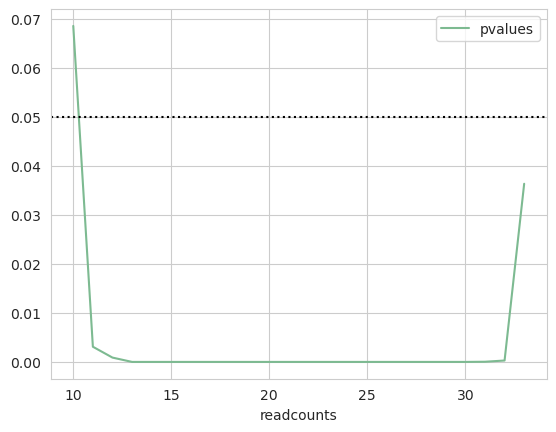

In [171]:
fig, ax = plt.subplots()

equalised_ts.plot.line(x="readcounts", y="pvalues", ax=ax)
ax.axhline(0.05, c="black", ls=":")


In [51]:
stats.ttest_ind(depthEqualizer(hmc_df_wide, 17)["percentMeth_TAB_5hmC"], depthEqualizer(hmc_df_wide, 17)["percentMeth_Nanopore_5hmC"])

Ttest_indResult(statistic=1.5404128620425146, pvalue=0.12346232174359327)

In [27]:
resample_test = hmc_df_wide.loc[(hmc_df_wide.loc[:, "readCount_Nanopore_5hmC"] >= 14) & (hmc_df_wide.loc[:, "readCount_Nanopore_5hmC"] <= 16) &
                                (hmc_df_wide.loc[:, "readCount_TAB_5hmC"] >= 14) & (hmc_df_wide.loc[:, "readCount_TAB_5hmC"] <= 16)]

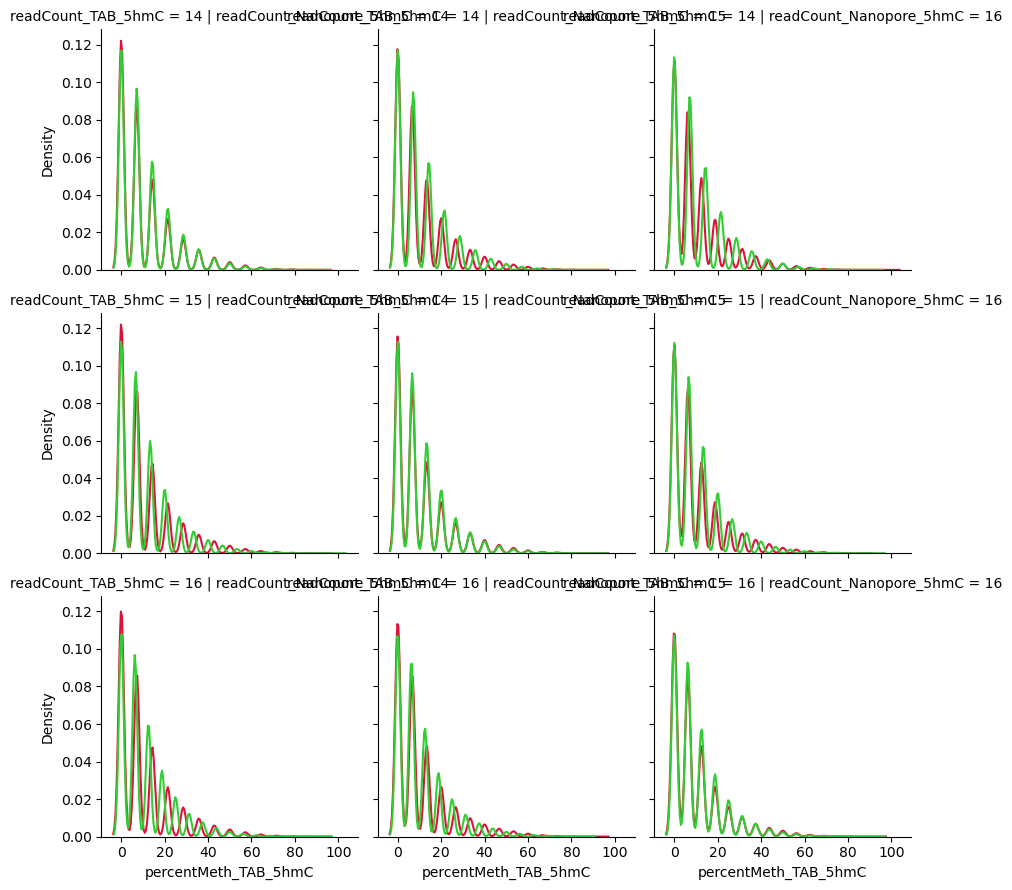

In [38]:
import seaborn as sns

fg = sns.FacetGrid(resample_test, col="readCount_Nanopore_5hmC", row="readCount_TAB_5hmC")
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore_5hmC", color="crimson")
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB_5hmC", color="limegreen")

In [40]:
from scipy import stats
from sklearn import metrics

three_mod_thresh = 15

two_mod_comp = [depthEqualizer(two_mod_wide, 20)["percentMeth_WGBS"], depthEqualizer(two_mod_wide, 20)["percentMeth_Nanopore"]]
mc_comp = [depthEqualizer(mc_df_wide, three_mod_thresh)["percentMeth_oxBS_5mC"], depthEqualizer(mc_df_wide, three_mod_thresh)["percentMeth_Nanopore_5mC"]]
hmc_comp = [depthEqualizer(hmc_df_wide, three_mod_thresh)["percentMeth_TAB_5hmC"], depthEqualizer(hmc_df_wide, three_mod_thresh)["percentMeth_Nanopore_5hmC"]]

print(f"Two Mod: MWU {stats.mannwhitneyu(*two_mod_comp).pvalue}\n5mC: MWU {stats.mannwhitneyu(*mc_comp).pvalue}\n5hmC: MWU {stats.mannwhitneyu(*hmc_comp).pvalue}\n")
print(f"Two Mod: KS {stats.stats.ks_2samp(*two_mod_comp).pvalue}\n5mC: KS {stats.stats.ks_2samp(*mc_comp).pvalue}\n5hmC: KS {stats.stats.ks_2samp(*hmc_comp).pvalue}\n")
print(f"Two Mod: AD {stats.anderson_ksamp(two_mod_comp)}\n5mC: AD {stats.anderson_ksamp(mc_comp)}\n5hmC: AD {stats.anderson_ksamp(hmc_comp)}\n")
print(f"Two Mod: rho {stats.spearmanr(*two_mod_comp)}\n5mC: rho {stats.spearmanr(*mc_comp)}\n5hmC: rho {stats.spearmanr(*hmc_comp)}\n")

Two Mod: MWU 2.9504059163278974e-57
5mC: MWU 1.1842474854462445e-14
5hmC: MWU 9.774417973322553e-17

Two Mod: KS 1.2008902782041621e-164
5mC: KS 0.0
5hmC: KS 0.0

Two Mod: AD Anderson_ksampResult(statistic=315.7677919611041, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
5mC: AD Anderson_ksampResult(statistic=1586.6875840903476, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
5hmC: AD Anderson_ksampResult(statistic=1945.8771007201349, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

Two Mod: rho SignificanceResult(statistic=0.836736166725972, pvalue=0.0)
5mC: rho SignificanceResult(statistic=0.6118337400000933, pvalue=0.0)
5hmC: rho SignificanceResult(statistic=0.43000189575390857, pvalue=0.0)



/tmp/ipykernel_17387/2826273040.py:11: DeprecationWarning: Please use `ks_2samp` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  print(f"Two Mod: KS {stats.stats.ks_2samp(*two_mod_comp).pvalue}\n5mC: KS {stats.stats.ks_2samp(*mc_comp).pvalue}\n5hmC: KS {stats.stats.ks_2samp(*hmc_comp).pvalue}\n")
/tmp/ipykernel_17387/2826273040.py:12: UserWarning: p-value floored: true value smaller than 0.001
  print(f"Two Mod: AD {stats.anderson_ksamp(two_mod_comp)}\n5mC: AD {stats.anderson_ksamp(mc_comp)}\n5hmC: AD {stats.anderson_ksamp(hmc_comp)}\n")


In [43]:
stats.skew(two_mod_wide["percentMeth_Nanopore"]), stats.skew(mc_df_wide["percentMeth_Nanopore_5mC"]), stats.skew(hmc_df_wide["percentMeth_Nanopore_5hmC"])

(-1.2783352852594665, -1.4239999214889174, 1.7228937194182543)

In [77]:
r_two_mod, r_mc, r_hmc = stats.pearsonr(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]).statistic, stats.pearsonr(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]).statistic, stats.pearsonr(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]).statistic
mae_two_mod, mae_mc, mae_hmc = metrics.mean_absolute_error(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]), metrics.mean_absolute_error(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]), metrics.mean_absolute_error(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"])
rmse_two_mod, rmse_mc, rmse_hmc = metrics.mean_squared_error(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"], squared=False), metrics.mean_squared_error(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"], squared=False), metrics.mean_squared_error(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"], squared=False)
msd_two_mod, msd_mc, msd_hmc = mean_signed_deviation(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]), mean_signed_deviation(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]), mean_signed_deviation(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"])

print(f"Binary caller:\tr={r_two_mod}\tMAD={mae_two_mod}\tRMSE={rmse_two_mod}\tMSD={msd_two_mod}\n5mC caller:\tr={r_mc}\tMAD={mae_mc}\tRMSE={rmse_mc}\tMSD={msd_mc}\n5hmC caller:\tr={r_hmc}\tMAD={mae_hmc}\tRMSE={rmse_hmc}\tMSD={msd_hmc}\n")

Binary caller:	r=0.9267654097510415	MAD=8.54308016362844	RMSE=11.794314813567036	MSD=-2.591962271736803
5mC caller:	r=0.8116068890682385	MAD=11.55831958913348	RMSE=15.22968942721506	MSD=0.9477068076219897
5hmC caller:	r=0.5342485630641761	MAD=8.708983529160735	RMSE=12.282170226070066	MSD=-0.17399765197043585



In [182]:
models = ["Binary caller", "5mC caller", "5hmC caller"]
for i, df in enumerate([two_mod_wide, mc_df_wide, hmc_df_wide]):
    roc = ROCPlot(df, 50)
    print(models[i], ":\tAUC=", roc.calculateAUC().round(2))

Binary caller :	AUC= 0.99
5mC caller :	AUC= 0.93
5hmC caller :	AUC= 0.89


In [10]:
from math import sqrt

def filterReadCountNanopore(df):
    mean = df.loc[:, "readCount_T"].mean() 
    max_depth = mean + 3*sqrt(mean) 
    filtered = df.loc[(df.loc[:, "readCount_T"] >= 10) & (df.loc[:, "readCount_T"] <= max_depth)]
    return filtered

In [11]:
nano_all = pd.read_csv('./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed', sep="\t", 
                       names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

nano_all["readCount_T"] = nano_all.loc[:, ("N_C", "N_mC", "N_hmC")].sum(axis="columns")
nano_all = filterReadCountNanopore(nano_all)
nano_all["percentMeth_C"] = nano_all["N_C"].divide(nano_all["readCount_T"])
nano_all["percentMeth_hmC"] = nano_all["N_hmC"].divide(nano_all["readCount_T"])
nano_all["percentMeth_mC"] = nano_all["N_mC"].divide(nano_all["readCount_T"])
nano_all.drop(columns=["mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"], inplace=True)

# Figure 2

In [1]:
import pandas as pd

dnmtools_out = pd.read_csv('./DNMTools_datasets/dnmtools_mlml_All.text', sep="\t", 
                           names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"])

nano_all = pd.read_csv("./intermediates/nanopore_three_mod.tsv", sep="\t", 
                       names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_C", "percentMeth_hmC"])

merged_three_mod = pd.merge(nano_all, dnmtools_out, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_Bisulphite"])
merged_three_mod["pred"] = merged_three_mod[["percentMeth_mC_Nanopore", "percentMeth_C_Nanopore", "percentMeth_hmC_Nanopore"]].idxmax(axis="columns").replace(["percentMeth_mC_Nanopore", "percentMeth_C_Nanopore", "percentMeth_hmC_Nanopore"], 
                                                                                                                                   ["5mC", "C", "5hmC"])
merged_three_mod["true"] = merged_three_mod[["percentMeth_mC_Bisulphite", "percentMeth_C_Bisulphite", "percentMeth_hmC_Bisulphite"]].idxmax(axis="columns").replace(["percentMeth_mC_Bisulphite", "percentMeth_C_Bisulphite", "percentMeth_hmC_Bisulphite"], 
                                                                                                                                   ["5mC", "C", "5hmC"])

merged_three_mod = merged_three_mod.loc[merged_three_mod.loc[:, "N_conflicts"] < 1]                                                                                                                                

In [5]:
from Checkpoints import Checkpoint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable
from graphing import linePlot

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

##### Figure 2 ##### 

fig2 = plt.figure(dpi=600, figsize=(11, 12))
gs2 = GridSpec(1, 2, fig2)

sns.set_style("whitegrid")
sns.set_palette("tab10")

##### ax00 ##### 

ax00 = fig2.add_subplot(gs2[0, 0])

ax00.set_aspect("equal")
ax00.plot(np.arange(0, 101, 1), "black", linestyle=":")

for i, df in enumerate([two_mod_wide, mc_df_wide, hmc_df_wide]):
    linePlot(df, ax00, label=["vs. WGBS", "vs. oxBS", "vs. TAB"][i], ls=["-", "--", ":"][i])

ax00.set_xlim((0, 100))
ax00.set_ylim((0, 100))
ax00.set_xlabel("Bisulphite \u03B2$_{\%}$")
ax00.set_ylabel("Nanopore \u03B2$_{\%}$")
ax00.legend()
ax00.set_title("A", loc="left")

##### ax01 ##### 

ax01 = fig2.add_subplot(gs2[0, 1])

cm = ConfusionMatrixDisplay.from_predictions(merged_three_mod["true"], merged_three_mod["pred"], normalize="true", colorbar=False, cmap="Greens", ax=ax01)

div01 = make_axes_locatable(ax01)
cax01 = div01.append_axes("right", size="5%", pad=0.05)
fig2.colorbar(cm.im_, cax01, label="Proportion of labels (normalised on bisulphite)")

ax01.set_xlabel("Nanopore prediction")
ax01.set_ylabel("Bisulphite prediction")
ax01.set_title("B", loc="left")

##### Save Figure ##### 

fig2.tight_layout()
fig2.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure2.png', bbox_inches="tight")
plt.close()

## Figure 2 Stats

In [27]:
from sklearn import metrics

metrics.cohen_kappa_score(merged_three_mod["pred"], merged_three_mod["true"])

0.7228583102038699

In [55]:
len(hmc_df_wide.loc[hmc_df_wide["percentMeth_TAB_5hmC"] >= 50])/len(hmc_df_wide), len(hmc_df_wide.loc[hmc_df_wide["percentMeth_Nanopore_5hmC"] >= 50])/len(hmc_df_wide)


(0.015771745075558313, 0.024463651203815568)

# Figure 3

In [8]:
import pandas as pd
from common import get_bismark, get_wgbs, filterDepth
import numpy as np
    
prediction_data = pd.read_csv('./DNMTools_datasets/dnmtools_mlml_oxBS_WGBS.text', sep="\t", 
                           names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"]).query("N_conflicts == 0")

nano_all = pd.read_csv("./intermediates/nanopore_three_mod.tsv", sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_C", "percentMeth_hmC"])
nano_v_predicted = pd.merge(nano_all, prediction_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_MLML"])

tab_data = filterDepth(get_bismark('./data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov', "5hmC"))
tab_data_v_predicted = pd.merge(tab_data, prediction_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_MLML"]).rename(
    columns={"percentMeth" : "percentMeth_hmC_TAB",
             "percentMeth_mC" : "percentMeth_mC_MLML",
             "percentMeth_hmC" : "percentMeth_hmC_MLML",
             "percentMeth_C" : "percentMeth_C_MLML"}
)
tab_data_v_predicted["percentMeth_hmC_TAB"] = tab_data_v_predicted["percentMeth_hmC_TAB"].div(100)

In [9]:
wgbs_data = filterDepth(get_wgbs('./data/WGBS_data/mm39_ENCSR893RHD_merged.bed'))
oxbs_data = filterDepth(get_bismark("./data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed", "5mC"))

subtraction_data = pd.merge(oxbs_data, wgbs_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_oxBS", "_WGBS"])
subtraction_data["percentMeth_hmC_subtraction"] = subtraction_data["percentMeth_WGBS"].subtract(subtraction_data["percentMeth_oxBS"])
subtraction_data["percentMeth_C_subtraction"] = np.subtract(100, subtraction_data["percentMeth_WGBS"])

subtraction_data_rel = pd.merge(subtraction_data, tab_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_subtraction", "_TAB"]).rename(columns={"percentMeth" : "percentMeth_5hmC_TAB"})

In [17]:
from sklearn import preprocessing
from Checkpoints import Checkpoint

subtraction_data_rel["bin"] = pd.cut(subtraction_data_rel["percentMeth_5hmC_TAB"], 101, labels=np.arange(0, 101, 1))
nano_v_predicted["bin"] = pd.cut(nano_v_predicted["percentMeth_hmC_MLML"], 101, labels=np.arange(0, 101, 1))
tab_data_v_predicted["bin"] = pd.cut(tab_data_v_predicted["percentMeth_hmC_TAB"], 101, labels=np.arange(0, 101, 1))

binariser_big = preprocessing.Binarizer(threshold=50)
binariser_small = preprocessing.Binarizer(threshold=0.50)

if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

hmc_df_wide["binarised"] = binariser_big.fit_transform(np.reshape(hmc_df_wide["percentMeth_TAB_5hmC"].to_numpy(), (-1, 1)))
subtraction_data_rel["binarised"] = binariser_big.fit_transform(np.reshape(subtraction_data_rel["percentMeth_5hmC_TAB"].to_numpy(), (-1, 1)))
nano_v_predicted["binarised"] = binariser_small.fit_transform(np.reshape(nano_v_predicted["percentMeth_hmC_MLML"].to_numpy(), (-1, 1)))
tab_data_v_predicted["binarised"] = binariser_small.fit_transform(np.reshape(tab_data_v_predicted["percentMeth_hmC_TAB"].to_numpy(), (-1, 1)))

In [5]:
def getPred(df, kind):
    if kind == "Nanopore":
        df["pred"] = df[["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"]].idxmax(axis="columns").replace(
            ["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"], ["C", "5mC", "5hmC"]
            )
    elif kind == "MLML":
        df["pred"] = df[["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"]].idxmax(axis="columns").replace(
            ["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"], ["C", "5mC", "5hmC"]
            )

    return df["pred"]
    
def getTrue(df, kind):
    if kind == "TAB":
        df["true"] = df[["percentMeth_C_TAB", "percentMeth_mC_TAB", "percentMeth_hmC_TAB"]].idxmax(axis="columns").replace(
            ["percentMeth_C_TAB", "percentMeth_mC_TAB", "percentMeth_hmC_TAB"], ["C", "5mC", "5hmC"]
            )
    elif kind == "MLML":
        df["true"] = df[["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"]].idxmax(axis="columns").replace(
            ["percentMeth_C_MLML", "percentMeth_mC_MLML", "percentMeth_hmC_MLML"], ["C", "5mC", "5hmC"]
            )
    elif kind == "Nanopore":
        df["true"] = df[["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"]].idxmax(axis="columns").replace(
            ["percentMeth_C_Nanopore", "percentMeth_mC_Nanopore", "percentMeth_hmC_Nanopore"], ["C", "5mC", "5hmC"]
            )
    return df["true"]

In [31]:
dnmtools_out = pd.read_csv('./DNMTools_datasets/dnmtools_mlml_All.text', sep="\t", 
                           names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"]).query("N_conflicts == 0")

tab_vs_predicted_CM = dnmtools_out.merge(prediction_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_MLML"])
# nano_vs_predicted_CM = dnmtools_out.merge(nano_all, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_Nanopore"])
# nano_vs_mlml_CM = prediction_data.merge(nano_all, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_MLML", "_Nanopore"])

In [20]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from graphing import linePlot
# from sklearn.metrics import ConfusionMatrixDisplay
# from mpl_toolkits.axes_grid1 import make_axes_locatable

##### Figure 3 ##### 

fig3 = plt.figure("fig3", figsize=(10, 5), dpi=600)
gs3 = GridSpec(1, 2)

sns.set_style("whitegrid")

##### ax00 ##### 

ax00 = fig3.add_subplot(gs3[0, 0])
ax00.set_aspect("equal")

ax00.plot(np.arange(0, 101, 1), "black", linestyle=":")
sns.lineplot(hmc_df_wide, x="percentMeth_TAB_5hmC", y="percentMeth_Nanopore_5hmC", errorbar=("pi", 50), ls="-", label="Nanopore (Y) vs. TAB", ax=ax00)
sns.lineplot(subtraction_data_rel, x="percentMeth_5hmC_TAB", y="percentMeth_hmC_subtraction", errorbar=("pi", 50), ls="--", label="Subtraction (Y) vs. TAB", ax=ax00)
sns.lineplot(x=tab_data_v_predicted["percentMeth_hmC_TAB"]*100, y=tab_data_v_predicted["percentMeth_hmC_MLML"]*100, errorbar=("pi", 50), ls="-.", label="MLML (Y) vs. TAB", ax=ax00)
# sns.lineplot(x=nano_v_predicted["bin"], y=nano_v_predicted["percentMeth_hmC_Nanopore"]*100, errorbar=("pi", 50), ls=":", label="MLML vs. Nanopore", ax=ax00)

ax00.set_title("A", loc="left")
ax00.legend()
ax00.set_xlabel("TAB \u03B2$_{\%}$")
ax00.set_ylabel("Compared method \u03B2$_{\%}$")

##### ax01 ##### 

from graphing import ROCPlot
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

ax01 = fig3.add_subplot(gs3[0, 1])

RocCurveDisplay.from_predictions(hmc_df_wide["binarised"], hmc_df_wide["percentMeth_Nanopore_5hmC"], label="Nanopore vs. TAB", ls="-", ax=ax01)
RocCurveDisplay.from_predictions(subtraction_data_rel["binarised"], subtraction_data_rel["percentMeth_hmC_subtraction"], label="Subtraction vs. TAB", ls="--", ax=ax01)
RocCurveDisplay.from_predictions(tab_data_v_predicted["binarised"], tab_data_v_predicted["percentMeth_hmC_MLML"], label="MLML vs. TAB", ls="-.", ax=ax01)
# RocCurveDisplay.from_predictions(nano_v_predicted["binarised"], nano_v_predicted["percentMeth_hmC_Nanopore"], label="MLML vs. Nanopore", ls=":", ax=ax01)

ax01.set_title("B", loc="left")
ax01.legend()

##### ax1 ##### 

# ax1 = fig3.add_subplot(gs3[1, 1:3])
# cm1 = ConfusionMatrixDisplay.from_predictions(getTrue(tab_vs_predicted_CM, "TAB"), getPred(tab_vs_predicted_CM, "MLML"), normalize="true", cmap="Greens", colorbar=False, ax=ax1)
# div1 = make_axes_locatable(ax1)
# cax1 = div1.append_axes("right", size="5%", pad=0.05)

# fig3.colorbar(cm1.im_, cax1, label="Proportion of labels\n(normalised on TAB labels)")

# ax1.set_title("C", loc="left")
# ax1.set_xlabel("TAB dominant state")
# ax1.set_ylabel("MLML dominant state")

##### Save Figure ##### 

fig3.tight_layout()
fig3.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure3.png', bbox_inches="tight")
plt.close()

## Figure 3 Stats

In [7]:
from scipy import stats
from sklearn import metrics

def mean_signed_deviation(est, pred):
    msd = np.average(pred - est)
    return msd

orig_comp = [hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]]
tab_comp = [tab_data_v_predicted["percentMeth_hmC_TAB"], tab_data_v_predicted["percentMeth_hmC_MLML"]]
subtraction_comp = [subtraction_data_rel["percentMeth_5hmC_TAB"], subtraction_data_rel["percentMeth_hmC_subtraction"]]
nano_comp = [nano_v_predicted["percentMeth_hmC_MLML"], nano_v_predicted["percentMeth_hmC_Nanopore"]]

print(f"TAB vs. Nanopore: r={stats.pearsonr(*orig_comp).statistic}\tSpearman p={stats.spearmanr(*orig_comp).statistic}\tMAD={metrics.mean_absolute_error(*orig_comp)}\tRMSE={metrics.mean_squared_error(*orig_comp, squared=False)}\tMSD={mean_signed_deviation(*orig_comp)}\n\
        MLML vs. TAB: r={stats.pearsonr(*tab_comp).statistic}\tSpearman p={stats.spearmanr(*tab_comp).statistic}\tMAD={metrics.mean_absolute_error(*tab_comp)}\tRMSE={metrics.mean_squared_error(*tab_comp, squared=False)}\tMSD={mean_signed_deviation(*tab_comp)}\n\
        MLML vs. Nanopore: r={stats.pearsonr(*nano_comp).statistic}\tSpearman p={stats.spearmanr(*nano_comp).statistic}\tMAD={metrics.mean_absolute_error(*nano_comp)}\tRMSE={metrics.mean_squared_error(*nano_comp, squared=False)}\tMSD={mean_signed_deviation(*nano_comp)}\n\
        Subtraction vs. TAB: r={stats.pearsonr(*subtraction_comp).statistic}\tSpearman p={stats.spearmanr(*subtraction_comp).statistic}\tMAD={metrics.mean_absolute_error(*subtraction_comp)}\tRMSE={metrics.mean_squared_error(*subtraction_comp, squared=False)}\tMSD={mean_signed_deviation(*subtraction_comp)}")

TAB vs. Nanopore: r=0.5291749303121095	Spearman p=0.419630433268654	MAD=8.818819090387006	RMSE=12.454925338220514	MSD=-0.21194548358786908
        MLML vs. TAB: r=0.37481546204681865	Spearman p=0.2617466174264021	MAD=0.0913354572338189	RMSE=0.12862253766918755	MSD=-0.005083490946388437
        MLML vs. Nanopore: r=0.3084148353640208	Spearman p=0.21863025666999789	MAD=0.094292091829717	RMSE=0.13062199369706842	MSD=0.009329907029727596
        Subtraction vs. TAB: r=0.34552380960980067	Spearman p=0.2554517563529673	MAD=11.430213240088747	RMSE=15.003716423109047	MSD=-2.9702134957173247


In [54]:
from sklearn import metrics

metrics.cohen_kappa_score(getTrue(tab_vs_predicted_CM, "TAB"), getPred(tab_vs_predicted_CM, "MLML")) #,  metrics.cohen_kappa_score(getTrue(nano_vs_mlml_CM, "Nanopore"), getPred(nano_vs_mlml_CM, "MLML"))

(0.8954658657657534, 0.7291478353074418)

In [58]:
metrics.roc_auc_score(hmc_df_wide["binarised"], hmc_df_wide["percentMeth_Nanopore_5hmC"]), metrics.roc_auc_score(subtraction_data_rel["binarised"], subtraction_data_rel["percentMeth_hmC_subtraction"]), metrics.roc_auc_score(tab_data_v_predicted["binarised"], tab_data_v_predicted["percentMeth_hmC_MLML"])

(0.8941589833588693, 0.8569679301432648, 0.8566796628913436)

In [57]:
ROCPlot(hmc_df_wide, 66).calculateAUC(), ROCPlot(nano_v_predicted, 0.66).calculateAUC(), ROCPlot(tab_data_v_predicted, 66).calculateAUC(), ROCPlot(subtraction_data_rel, 66).calculateAUC()

(0.9084987154472722, 0.8997360513642245, 0.884852459851316, 0.8854412015770458)

# Figure 4

In [1]:
import pandas as pd

hmc_df_wide = pd.read_csv("./intermediates/hmc_df_wide.tsv", sep="\t", names=["Chromosome", "Start", "End", "strand", "readCount_Nanopore", "percentMeth_Nanopore_5hmC", "readCount_TAB", "percentMeth_Bisulphite_5hmC"]).drop(columns=["readCount_Nanopore", "readCount_TAB"])

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from Checkpoints import Checkpoint
from mpl_toolkits.axes_grid1 import make_axes_locatable
from GroupCpGs import *
import numpy as np

##### Figure 5 #####

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired")[2:4])

fig5 = plt.figure(figsize=(10, 12), dpi=600)
gs5 = GridSpec(3, 2, fig5, height_ratios=(2, 2, 3))

##### ax0 ##### 

ax0 = fig5.add_subplot(gs5[0, :2])

FeatureAndGene(CpGIntersects(hmc_df_wide).group("features")).makeBoxplots(ax0)
ax0.set_title("A", loc="left")
ax0.set_xlabel("Genomic feature")
ax0.set_ylabel("Average CpG \u03B2$_{\%}$")
sns.move_legend(ax0, "upper left", title=None)

##### ax1 ##### 

ax1 = fig5.add_subplot(gs5[1, :2])

FeatureAndGene(CpGIntersects(hmc_df_wide).group("CGI")).makeBoxplots(ax1)
ax1.set_title("B", loc="left")
ax1.set_xlabel("Position relative to CGI")
ax1.set_ylabel("Average CpG \u03B2$_{\%}$")
sns.move_legend(ax1, "upper left", title=None)

##### ax20 #####

ax20 = fig5.add_subplot(gs5[2, 0])
ax20.set_aspect("equal")
gene_data = FeatureAndGene(CpGIntersects(hmc_df_wide).group("genes"), 10)
div20 = make_axes_locatable(ax20)
cax20 = div20.append_axes("right", size="5%", pad=0.05)

gene_data.makeHist("density", ax20, cax20)
ax20.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

# ax20.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=gene_r), ha="center")
# ax20.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")
ax20.set_ylim((-5.5, 3))
ax20.set_xlim((-5.5, 3))
ax20.set_xlabel("TAB enrichment")
ax20.set_ylabel("Nanopore enrichment")
ax20.set_title("C", loc="left")

##### ax21 ##### 

ax21 = fig5.add_subplot(gs5[2, 1])
ax21.set_aspect("equal")
tile_data = tiledGroup(CpGIntersects(hmc_df_wide).groupByGenomicWindow(300), 10)
div21 = make_axes_locatable(ax21)
cax21 = div21.append_axes("right", size="5%", pad=0.05)

tile_data.makeHist("density", ax21, cax21)
ax21.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

# ax21.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=tile_r), ha="center")
# ax21.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax21.set_ylim((-5.5, 3))
ax21.set_xlim((-5.5, 3))
ax21.set_xlabel("TAB enrichment")
ax21.set_ylabel("Nanopore enrichment")
ax21.set_title("D", loc="left")

##### Outputs #####

fig5.tight_layout()
fig5.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure5.png')
plt.close()

In [3]:
from GroupCpGs import *

tiledGroup(CpGIntersects(hmc_df_wide).groupByGenomicWindow(300), 10)

IndexError: indices are out-of-bounds

## Figure 4 Stats

In [73]:
from GroupCpGs import *

sns.set_style("whitegrid")
sns.set_palette("tab10")

In [32]:
hmc_df_wide = pd.read_csv("./intermediates/hmc_df_wide.tsv", sep="\t", names=["Chromosome", "Start", "End", "strand", "readCount_Nanopore", "percentMeth_Nanopore_5hmC", "readCount_TAB", "percentMeth_Bisulphite_5hmC"])

In [33]:
feature_df = CpGIntersects(hmc_df_wide).group("features")

In [146]:
eq_depth_test = hmc_df_wide.loc[(hmc_df_wide.loc[:, "readCount_Nanopore"] == 16) & (hmc_df_wide.loc[:, "readCount_TAB"] == 16)]
feature_df = CpGIntersects(eq_depth_test).group("features")

In [150]:
ew = pd.ExcelWriter("./outputs/Feature_Statistics.xlsx")

In [153]:
from scipy import stats

features = ["Intergenic", "Repeat", "Promoter", "5UTR", "TSS", "Intron", "Exon", "3UTR", "TTS"]
all_features = {}

for feature in features:
    df = feature_df.loc[feature_df.loc[:, "feature_type"] == feature]
    sws, swp = stats.shapiro(df["percentMeth_Nanopore"])
    pr = stats.pearsonr(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).statistic.round(3)
    sp = stats.spearmanr(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).statistic.round(3)
    t = stats.ttest_ind(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue.round(3)
    mwu = stats.mannwhitneyu(x=df["percentMeth_Nanopore"], y=df["percentMeth_TAB"]).pvalue.round(3)
    ks = stats.ks_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    cvm = stats.cramervonmises_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
    kw = stats.kruskal(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ab = stats.ansari(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue.round(3)
    feature_entry = {feature : 
                        {"Shapiro-Wilk stat" : round(sws, 3),
                        "Shapiro-Wilk p-value" : round(swp, 3),
                        "Pearson" : pr.round(3),
                        "Spearman" : sp.round(3),
                        "T-test" : t.round(3),
                        "Mann-Whitney" : mwu.round(3),
                        "Kolmogorov-Smirnov" : ks.round(3), 
                        "Cramer-Von Mises" : cvm.round(3), 
                        "Anderson-Darling" : round(ad, 3), 
                        "Kruskal-Wallis" : kw.round(3),
                        "Sites compared" : len(df)}
                        }
    all_features.update(feature_entry)

pd.DataFrame().from_dict(all_features).replace(0, "<0.001").to_excel(ew, "NoResample")

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/tmp/ipykernel_61746/1430029503.py:15: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue


In [154]:
ew.close()

## Figure 4 feature hydroxymethylation

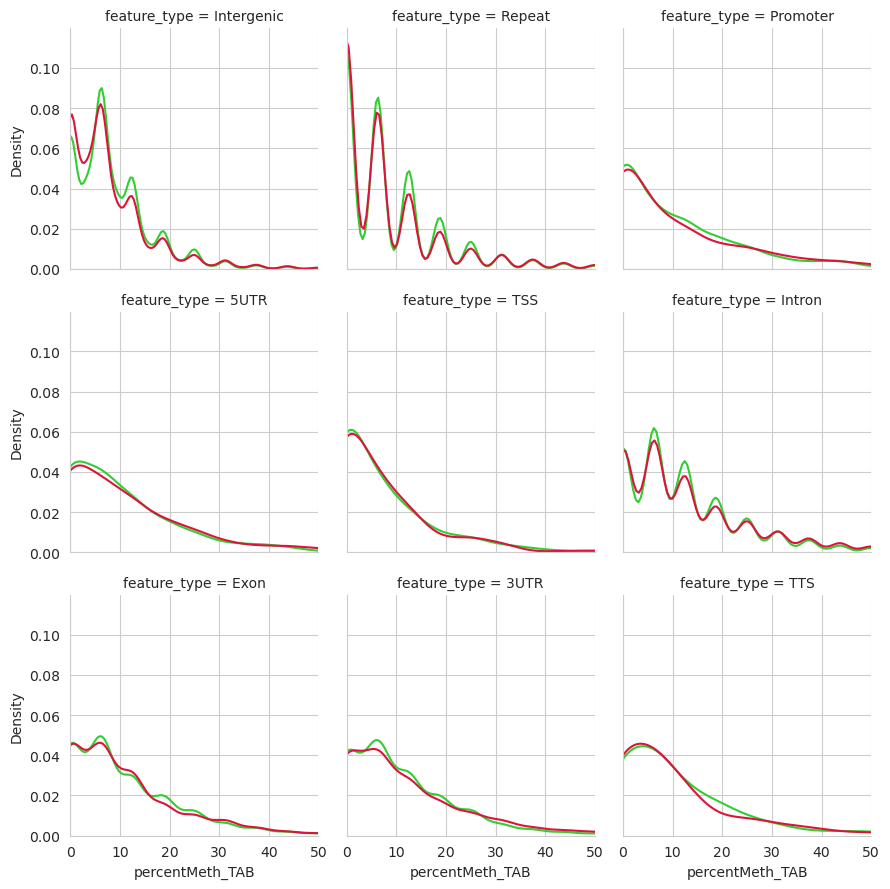

In [124]:
fg = sns.FacetGrid(feature_df, col="feature_type", xlim=(0, 50), col_wrap=3)
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore", color="limegreen")
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB", color="crimson")

## Figure 4 repeat hydroxymethylation

In [ ]:
rew = pd.ExcelWriter("./outputs/Repeat_Statistics.xlsx")

In [31]:
repeat_df = CpGIntersects(eq_depth_test).group("repeats")

NameError: name 'eq_depth_test' is not defined

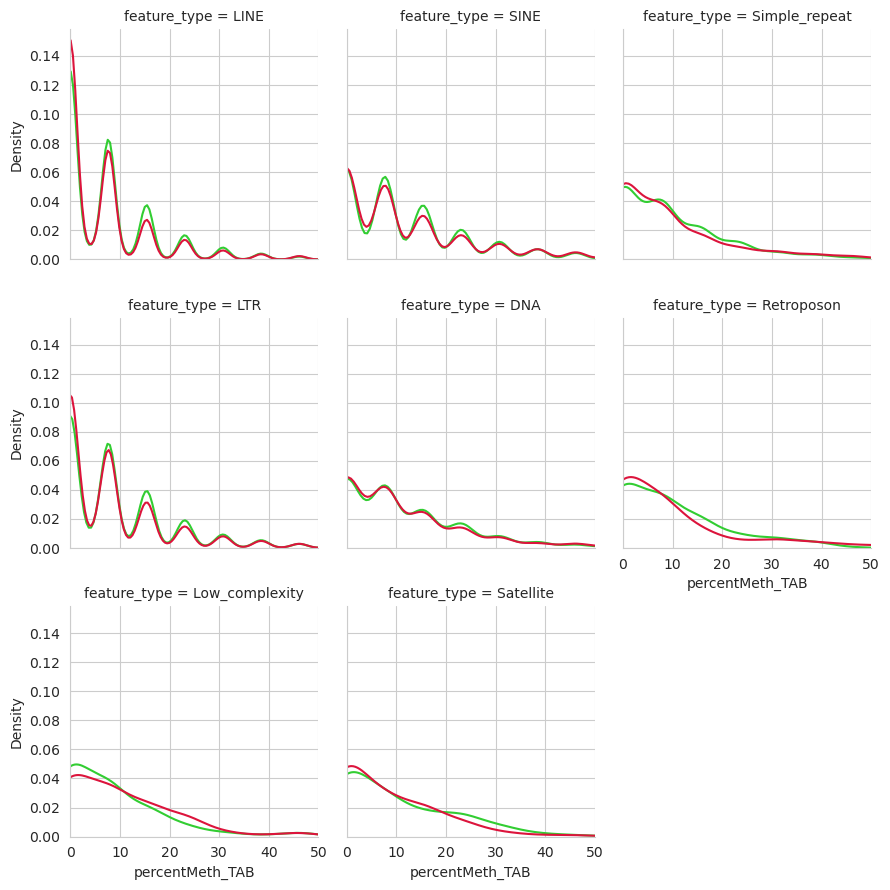

In [54]:
fg = sns.FacetGrid(repeat_df, col="feature_type", xlim=(0, 50), col_wrap=3)
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore", color="limegreen")
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB", color="crimson")

In [56]:
repeats = ["LINE", "SINE", "Simple_repeat", "LTR", "DNA", "Retroposon", "Low_complexity", "Satellite"]

for repeat in repeats:
    df = feature_df.loc[feature_df.loc[:, "feature_type"] == feature]
    sws, swp = stats.shapiro(df["percentMeth_Nanopore"])
    pr = stats.pearsonr(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).statistic.round(3)
    sp = stats.spearmanr(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).statistic.round(3)
    t = stats.ttest_ind(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue.round(3)
    mwu = stats.mannwhitneyu(x=df["percentMeth_Nanopore"], y=df["percentMeth_TAB"]).pvalue.round(3)
    ks = stats.ks_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    cvm = stats.cramervonmises_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
    kw = stats.kruskal(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ab = stats.ansari(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue.round(3)
    feature_entry = {feature : 
                        {"Shapiro-Wilk stat" : round(sws, 3),
                        "Shapiro-Wilk p-value" : round(swp, 3),
                        "Pearson" : pr.round(3),
                        "Spearman" : sp.round(3),
                        "T-test" : t.round(3),
                        "Mann-Whitney" : mwu.round(3),
                        "Kolmogorov-Smirnov" : ks.round(3), 
                        "Cramer-Von Mises" : cvm.round(3), 
                        "Anderson-Darling" : round(ad, 3), 
                        "Kruskal-Wallis" : kw.round(3),
                        "Sites compared" : len(df)}
                        }
    all_features.update(feature_entry)

pd.DataFrame().from_dict(all_features).replace(0, "<0.001").to_excel(ew, "NoResample")

LINE MW U: p < 1.2643515520679136e-161 KS: 0.0 CVM: 5.0072030188808014e-08 AD: 0.001 KW: 1.2643381204242188e-161
SINE MW U: p < 5.745481495207355e-15 KS: 0.0 CVM: 4.616244253519142e-08 AD: 0.001 KW: 5.7454528719570596e-15
Simple_repeat MW U: p < 0.00029250189095659444 KS: 1.3963207689491678e-38 CVM: 1.0923117965688789e-10 AD: 0.001 KW: 0.0002924434761301735
LTR MW U: p < 2.86237333164653e-101 KS: 0.0 CVM: 4.2067438532633616e-08 AD: 0.001 KW: 2.862343260688606e-101
DNA MW U: p < 0.0003797391699519101 KS: 2.3879682342231958e-88 CVM: 5.057902985328155e-10 AD: 0.001 KW: 0.0003797226362533906
Retroposon MW U: p < 0.0062307522279452755 KS: 1.7097463775203013e-14 CVM: 6.695633053555028e-07 AD: 0.001 KW: 0.00622484406101236
Low_complexity MW U: p < 0.5192249796817884 KS: 0.002716842615154834 CVM: 0.006256623619412038 AD: 0.04604389999689852 KW: 0.5186582312369836
Satellite MW U: p < 0.19770295341555166 KS: 0.0004394290389244031 CVM: 0.019879289067850303 AD: 0.10428546435624883 KW: 0.1973428035

/tmp/ipykernel_2394402/1332574835.py:8: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue


## Figure 4 CGI hydroxymethylation

In [57]:
cgi_df = CpGIntersects(eq_depth_test).group("CGI")
# cgi_df = cgi_df.copy().query("CpG_count > 2")

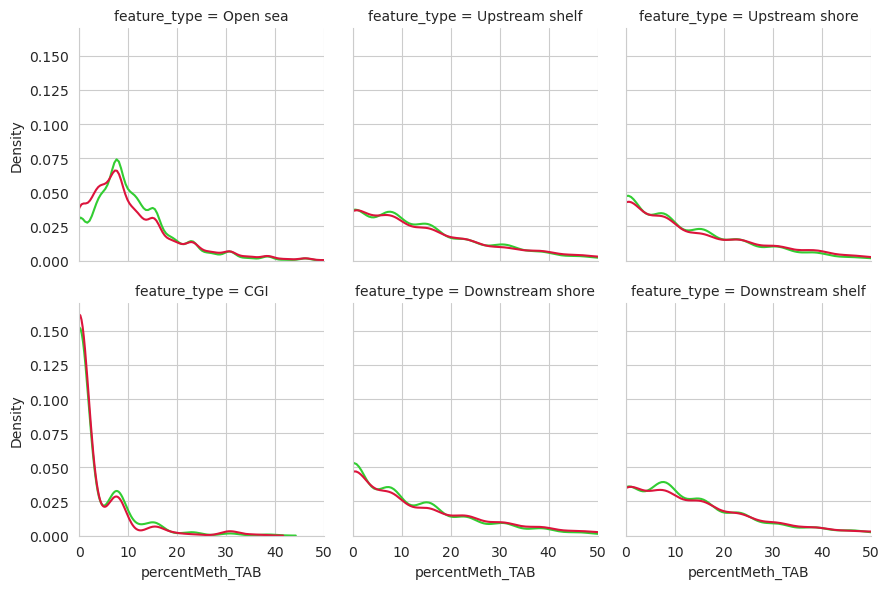

In [58]:
fg = sns.FacetGrid(cgi_df, col="feature_type", xlim=(0, 50), col_wrap=3)
fg.map_dataframe(sns.kdeplot, x="percentMeth_Nanopore", color="limegreen")
fg.map_dataframe(sns.kdeplot, x="percentMeth_TAB", color="crimson")

In [35]:
cgis = ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"]

for cgi in cgis:
    df = cgi_df.loc[cgi_df.loc[:, "feature_type"] == cgi]
    mwu = stats.mannwhitneyu(x=df["percentMeth_Nanopore"], y=df["percentMeth_TAB"]).pvalue
    ks = stats.ks_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    cvm = stats.cramervonmises_2samp(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
    kw = stats.kruskal(df["percentMeth_Nanopore"], df["percentMeth_TAB"]).pvalue
    print(cgi, "MW U: p <", mwu, "KS:", ks, "CVM:", cvm, "AD:", ad, "KW:", kw)

Open sea MW U: p < 6.978955358012615e-19 KS: 1.988504295415333e-133 CVM: 3.2782526693253544e-09 AD: 0.001 KW: 6.978935160834567e-19
Upstream shelf MW U: p < 0.354415143205404 KS: 6.754012325605763e-25 CVM: 4.1102676817672545e-11 AD: 0.001 KW: 0.35439815852707535
Upstream shore MW U: p < 0.0034873489188486833 KS: 1.377865166054312e-29 CVM: 2.745048632846192e-11 AD: 0.001 KW: 0.003487076850285982
CGI MW U: p < 0.5058840283196431 KS: 0.18761407787239476 CVM: 0.5613157617785028 AD: 0.25 KW: 0.5048367415431019
Downstream shore MW U: p < 0.010716301355133925 KS: 1.042856526757089e-26 CVM: 2.7950575187674076e-10 AD: 0.001 KW: 0.01071551584051771
Downstream shelf MW U: p < 0.45645000074048336 KS: 1.6898697592809941e-22 CVM: 5.526723523274768e-11 AD: 0.001 KW: 0.4564317533652299


/tmp/ipykernel_2394402/2350338455.py:8: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue
/tmp/ipykernel_2394402/2350338455.py:8: UserWarning: p-value capped: true value larger than 0.25
  ad = stats.anderson_ksamp([df["percentMeth_Nanopore"], df["percentMeth_TAB"]]).pvalue


## Loci for qPCR

In [4]:
hmc_df_wide = pd.read_csv("./intermediates/hmc_df_wide.tsv", sep="\t", names=["Chromosome", "Start", "End", "strand", "readCount_Nanopore", "percentMeth_Nanopore_5hmC", "readCount_TAB", "percentMeth_Bisulphite_5hmC"]).drop(columns=["readCount_Nanopore", "readCount_TAB"])

In [30]:
all_tiles = tiledGroup(CpGIntersects(hmc_df_wide).groupByGenomicWindow(200), 2)
all_tiles.exportTests(20)

<Axes: xlabel='Log2FromMean_TAB', ylabel='Log2FromMean_Nanopore'>

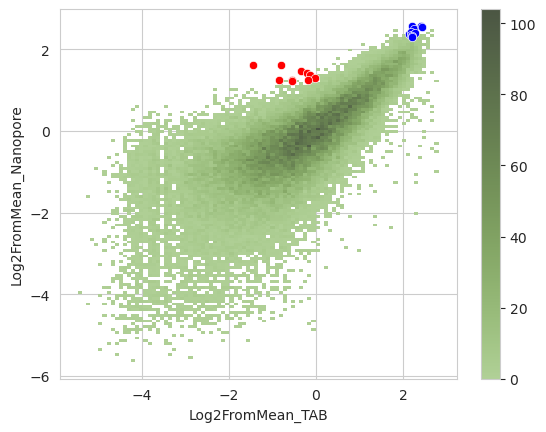

In [25]:
fig, ax = plt.subplots()
all_tiles.makeHist("count", ax=ax)
sns.scatterplot(all_tiles.NanoporePositiveGroupDF(10).df, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", c="r")
sns.scatterplot(all_tiles.positiveControlGroupDF(10).df, x="Log2FromMean_TAB", y="Log2FromMean_Nanopore", c="b")